In [78]:
%load_ext autoreload
%autoreload 2

## Standard libraries
import os
import numpy as np
import random
from PIL import Image
from types import SimpleNamespace
from dotenv import load_dotenv

load_dotenv()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data, Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torchvision.models as models

import lightning as L

from example_submission import *
from typing import Tuple

import wandb
from pytorch_lightning.loggers import WandbLogger

TASK_1_DATA_PUBLIC_PATH = os.getenv("TASK_1_DATA_PUBLIC_PATH")
TASK_1_DATA_PRIVATE_PATH = os.getenv("TASK_1_DATA_PRIVATE_PATH")
TASK_1_MODEL_PATH = os.getenv("TASK_1_MODEL_PATH")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'Dataset'

In [11]:
class ModifedDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.ids = dataset.ids
        self.imgs = dataset.imgs
        self.labels = [int(l) for l in dataset.labels]

        self.transform = transform

        self.number_of_classes = len(set(self.labels))
        self.classes_mapping = {label: i for i, label in enumerate(set(self.labels))}

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.classes_mapping[self.labels[index]]
        return id_, img, label

    def __len__(self):
        return len(self.ids)

In [39]:
transform = transforms.Compose([
    # transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.2980, 0.2962, 0.2987], std = [0.2886, 0.2875, 0.2889]),
])

public_dataset = torch.load("D:\Code\ensemble-ai\data\\task_1\pub.pt")
private_dataset = torch.load("D:\Code\ensemble-ai\data\\task_1\priv_out.pt")
# dataset = ModifedDataset(dataset, transform)

print(private_dataset.__class__)
private_dataset.membership = [-1 for _ in private_dataset.membership]
print(private_dataset.membership)

<class 'example_submission.MembershipDataset'>
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

In [21]:
print(len(set(public_dataset.labels)))
print(len(set(private_dataset.labels)))

44
44


[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 

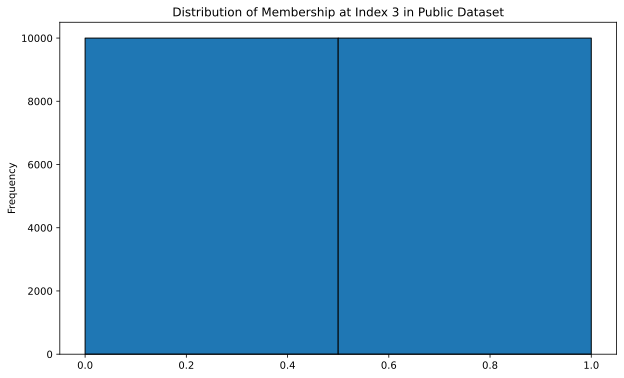

In [ ]:
import matplotlib.pyplot as plt

# Extract the labels from the public dataset
membership = [public_dataset.membership[i] for i in range(len(public_dataset))]

# Plot the distribution of the membership
plt.figure(figsize=(10, 6))
plt.hist(membership, bins=len(set(membership)), edgecolor='black')
plt.title('Distribution of Membership at Index 3 in Public Dataset')
plt.ylabel('Frequency')
plt.show()

In [40]:
batch_size = 256
private_loader = DataLoader(private_dataset, batch_size=batch_size)

In [41]:
for batch in private_loader:
    print(batch)
    break

[tensor([251500, 188458, 197856, 195124, 244309, 156489, 301921, 104556,  51198,
         18228,  67500,  40882, 141134, 165428, 121874, 111598, 245332, 155741,
        293665, 113568, 116817, 222038,  94598, 248501,  16315,  69947, 230764,
        253405, 204647,  67827,  48938,  35164, 280421,   2697,  26576,  81080,
        201932,  47948, 196797, 265354,  40384, 104627, 252052, 286629, 256287,
        242332, 263182, 111791, 288891, 269719, 159035,  35032, 266968,  27855,
          5308,  30691,  67172,  57268,  96094, 285774, 148933, 123440,  43712,
        181352,  72552,   7475, 249419, 194321,  81255, 213638,  48603, 131994,
        290168, 142112,  91876, 139946, 155224, 167305,  97765, 243161,  77437,
        128471, 292579, 305747, 292312,  58948,  76746,   8564, 190331,  34584,
        155732, 143860, 303746, 253470,  25051, 189778, 196883, 137464, 154272,
        106484, 138397, 224748,  23025,   3301, 183797,  61490, 133930, 152796,
         96978,  60072, 169559,   1850,

In [46]:
class LModule(L.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pass

    def validation_step(self, batch, batch_idx):
        pass

    def test_step(self, batch, batch_idx):
        pass

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

# class Model(nn.Module):
#     def __init__(self, model_name, num_classes):
#         super().__init__()
#         match model_name:
#             case "resnet18":
#                 self.backbone = models.resnet18(pretrained=True)
#             case _:
#                 raise NotImplementedError

#         self.representation = nn.Linear(self.backbone.fc.in_features, 1024)
#         self.projection = nn.Linear(1024, num_classes)
            
#         self.backbone.fc = nn.Identity()
    
#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.representation(x)
#         x = self.projection(x)
#         return x

In [64]:
model = models.resnet18(pretrained=True)
# model.to("cuda")
model.fc = nn.Linear(model.fc.in_features, 44)
model.load_state_dict(torch.load("D:\Code\ensemble-ai\\task_1\\01_MIA_69.pt",  weights_only=False))
lightning_model = LModule(model)
trainer = L.Trainer(max_epochs=100, accelerator="gpu" if torch.cuda.is_available() else "cpu")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [58]:
from torchinfo import summary

print(summary(model, input_size=(1, 3, 32, 32)))

AttributeError: 'collections.OrderedDict' object has no attribute 'parameters'

In [70]:
lightning_model.eval()
predictions = []
probabilities = []

print(lightning_model.model)

with torch.no_grad():
    for batch in private_loader:
        ids, imgs, labels, _ = batch
        # imgs = imgs.to(DEVICE)
        outputs = lightning_model(imgs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())

# Print the probabilities for the highest class
highest_class_probs = [max(prob) for prob in probabilities]
print(highest_class_probs)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [74]:
print(len(private_dataset.ids))
print(len(highest_class_probs))
results = []
for id, score in zip(private_dataset.ids, highest_class_probs):
    print(id, score)
    if score > 0.5:
        results.append(0.9)
    else:
        results.append(0.1)

df = pd.DataFrame(
    {
        "ids": private_dataset.ids,
        "score": results,
    }
)

20000
20000
251500 0.8707955
188458 0.48725492
197856 0.9971591
195124 0.8200633
244309 0.9859875
156489 0.975943
301921 0.47892424
104556 0.43045822
51198 0.7378483
18228 0.6707935
67500 0.6782947
40882 0.9864825
141134 0.5599127
165428 0.7635044
121874 0.73786664
111598 0.8582073
245332 0.9968811
155741 0.9994253
293665 0.9859191
113568 0.8685305
116817 0.6390896
222038 0.9838717
94598 0.9787228
248501 0.6098152
16315 0.65242255
69947 0.9965809
230764 0.40542743
253405 0.87807196
204647 0.33682895
67827 0.6804993
48938 0.71522915
35164 0.81203115
280421 0.993775
2697 0.9875443
26576 0.78597486
81080 0.515223
201932 0.99826294
47948 0.8144537
196797 0.8644271
265354 0.6386321
40384 0.80657345
104627 0.9610505
252052 0.9991911
286629 0.9955314
256287 0.997349
242332 0.9942285
263182 0.9940759
111791 0.83075416
288891 0.9961267
269719 0.4296488
159035 0.99999917
35032 0.9877686
266968 0.99874204
27855 0.73273283
5308 0.75449204
30691 0.9850036
67172 0.9851089
57268 0.85545594
96094 0.91

In [75]:
df.to_csv("submission.csv", index=False)

# result = requests.post(
#     URL,
#     headers={"token": TOKEN},
#     files={
#         "csv_file": ("submission.csv", open("./submission.csv", "rb"))
#     }
# )

# print(result.status_code, result.text)